In [2]:
from generate_maps import load_s3dis_point_cloud, get_topologial_map

file_path = 'data/noXYZ_area_4_no_xyz/area_4/3d/pointcloud.mat'  
point_sum_points, point_sum_colors, scene_names = load_s3dis_point_cloud(file_path)
print("success load!")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Keys in the .mat file: ['Area_4']
Processing conferenceRoom_1...
Processing conferenceRoom_2...
Processing conferenceRoom_3...
Processing hallway_1...
Processing hallway_2...
Processing hallway_3...
Processing hallway_4...
Processing hallway_5...
Processing hallway_6...
Processing hallway_7...
Processing hallway_8...
Processing hallway_9...
Processing hallway_10...
Processing hallway_11...
Processing hallway_12...
Processing hallway_13...
Processing hallway_14...
Processing lobby_1...
Processing lobby_2...
Processing office_1...
Processing office_2...
Processing office_3...
Processing office_4...
Processing office_5...
Processing office_6...
Processing office_7...
Processing office_8...
Processing office_9...
Processing office_10...
Processing office_11...
Processing office_12...
Processing office_13...
Processing offic

In [3]:
import generate_maps
import importlib
importlib.reload(generate_maps)

top_view_map, obstacle_map, separate_obstacle_map, all_centers = generate_maps.get_top_view_map(point_sum_points, point_sum_colors, scene_names)


In [4]:
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import numpy as np

def generate_landmarks(s_start, s_end, top_view_map, obstacle_map):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(25, 25))
    ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)

    pil_img = Image.fromarray(top_view_map)
    draw = ImageDraw.Draw(pil_img)

    font_size = 25
    # Load a font (make sure you specify a valid .ttf font path on your system)
    font = ImageFont.load_default(font_size)

    # Number of circles to draw
    num_labels = 80

    # Circle radius
    r = 20

    # Image dimensions
    height, width, _ = top_view_map.shape

    i = 1
    valid_points = {}
    while i < num_labels: 
        # Generate random (x, y) within image boundaries
        x = random.randint(r, width - r)
        y = random.randint(r, height - r)
        
        if ob_map[y, x] == 1:
            continue
        
        # Check distance from all previously placed points
        too_close = False
        min_dist = 100
        for label_key, (px, py) in valid_points.items():
            if (y - px)**2 + (x - py)**2 < min_dist**2:
                too_close = True
                break
        
        # If this point is too close to an existing point, skip it
        if too_close:
            continue
        
        # Draw the circle
        draw.ellipse(
            [(x - r, y - r), (x + r, y + r)],
            fill="white",       # circle fill color
            outline="black",    # circle outline color
            width=2             # outline thickness
        )
        
        # Center the text inside the circle
        label = str(i)
        text_x = x - (font_size / 2)
        text_y = y - (font_size / 2)
        draw.text((text_x, text_y), label, fill="black", font=font)
        
        valid_points[str(i)] = (y, x)
        i += 1
        
        
    # mark start and end
    font_size = 30
    # Load a font (make sure you specify a valid .ttf font path on your system)
    font = ImageFont.load_default(font_size)
    x = s_start[1]
    y = s_start[0]
    # Draw the circle
    draw.ellipse(
        [(x - r, y - r), (x + r, y + r)],
        fill="white",       # circle fill color
        outline="red",    # circle outline color
        width=4             # outline thickness
    )

    # Center the text inside the circle
    label = 'S'
    text_x = x - (font_size / 3)
    text_y = y - (font_size / 1.5)
    draw.text((text_x, text_y), label, fill="red", font=font)
    valid_points[label] = (y, x)


    x = s_end[1]
    y = s_end[0]
    # Draw the circle
    draw.ellipse(
        [(x - r, y - r), (x + r, y + r)],
        fill="white",       # circle fill color
        outline="red",    # circle outline color
        width=4             # outline thickness
    )

    # Center the text inside the circle
    label = 'D'
    text_x = x - (font_size / 3)
    text_y = y - (font_size / 1.5)
    draw.text((text_x, text_y), label, fill="red", font=font)
    valid_points[label] = (y, x)

        
    pil_img.show()
    buffered = BytesIO()
    pil_img.save(buffered, format="JPEG")

    return buffered, valid_points

In [20]:
import numpy as np
obstacle_map_rgb = np.stack([obstacle_map] * 3, axis=-1)
obstacle_map_rgb = (obstacle_map_rgb * 255).astype(np.uint8)

# Convert to PIL image
pil_image = Image.fromarray(obstacle_map_rgb)
pil_image.show()

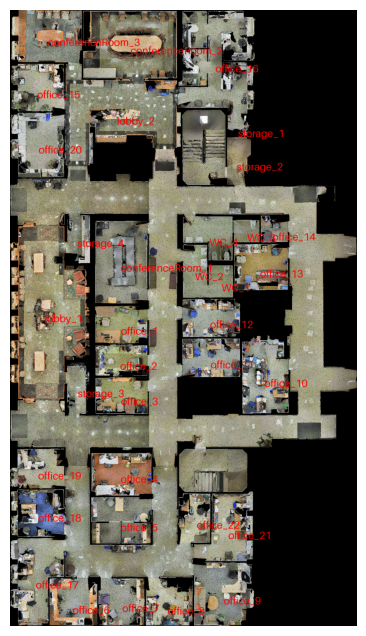

In [3]:
import path_finding
importlib.reload(path_finding)
import matplotlib.pyplot as plt

img = path_finding.write_scene_name(top_view_map, all_centers)
plt.figure(figsize=(10, 8)) 
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.show()

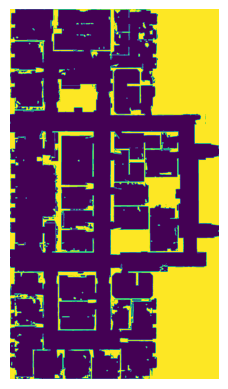

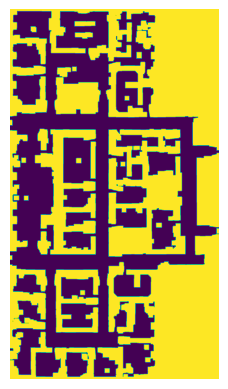

In [4]:
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(25, 25))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)



plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [5]:
import networkx as nx
import cv2
import numpy as np
from io import BytesIO
import path_finding
import system_prompt
import chat_utils

importlib.reload(path_finding)
importlib.reload(chat_utils)

import os

filename = "3"


def get_all_candidate_maps(source_node, target_node):

    s_start = all_centers[source_node]
    s_end = all_centers[target_node]
    
    buffered, valid_points = generate_landmarks(s_start, s_end, top_view_map, obstacle_map)
    # obstacle_map_rgb = np.stack([obstacle_map] * 3, axis=-1)
    # obstacle_map_rgb = (obstacle_map_rgb * 255).astype(np.uint8)
    # obs_with_lm = path_finding.write_landmark_name(obstacle_map_rgb, valid_points)
    # # obs_with_lm = Image.fromarray(obstacle_map_rgb)
    # buffered_obs = BytesIO()
    # obs_with_lm.save(buffered_obs, format="JPEG")
    
    image_path = "/home/ybg/Project/Privacy-Aware-Nav/img/4_example.PNG"
    message = chat_utils.path_message_prepare(system_prompt.find_path_prompt, buffered, image_path)
    response_message = chat_utils.chat_with_gpt4v(message)
    ground_json = response_message["paths"]
    
    all_topo_paths = []
    for k, v in ground_json.items():
        all_topo_paths.append(v)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph_for_large(all_topo_paths, obstacle_map, valid_points)

    save_directory = f"map_with_path/area_{filename}/{source_node}-{target_node}/"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = top_view_map.copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number(map_with_path, i)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像.
        # map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
        
    # self-critique
    critique_message = chat_utils.critique_message_prepare(system_prompt.self_critique_prompt, candidate_map_list)

    response_message = chat_utils.chat_with_gpt4v(message+critique_message)
    ground_json = response_message["self_critique"]
    print(ground_json)
    while ground_json == "0":
        all_topo_paths = []
        for k, v in response_message["paths"].items():
            all_topo_paths.append(v)
            
        all_geo_paths = path_finding.path_plan_from_topo_graph_for_large(all_topo_paths, obstacle_map, valid_points)

        candidate_map_list = []
        for i, geo_path in enumerate(all_geo_paths):
            map_with_path = top_view_map.copy()
            x_indices, y_indices = zip(*geo_path)
            path_map = np.zeros(obstacle_map.shape)
            path_map[x_indices, y_indices] = 1
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
            path_map = cv2.dilate((path_map).astype('uint8'), kernel)
            map_with_path[path_map == 1] = [255, 0 , 0]
            
            map_with_path = path_finding.write_number(map_with_path, i)
            # map_with_path = path_finding.write_scene_name(map_with_path, valid_points)
            buffered = BytesIO()
            map_with_path.save(buffered, format="JPEG")
            candidate_map_list.append(buffered)

            # 使用 Matplotlib 显示图像
            # 使用 Matplotlib 显示图像.
            # map_with_path.save(save_directory+f"vis_{i}.png")
            plt.imshow(map_with_path)
            plt.axis('off')  # 隐藏坐标轴
            plt.show()
            
        critique_message = chat_utils.critique_message_prepare(system_prompt.self_critique_prompt, candidate_map_list)

        response_message = chat_utils.chat_with_gpt4v(message+critique_message)
        ground_json = response_message["self_critique"]
        
    return candidate_map_list, all_geo_paths

In [6]:
importlib.reload(path_finding)
from PIL import Image
from astar import AStar

def get_metric(source_node, target_node, all_geo_paths):
    
    evaluation_map = path_finding.get_evaulation_map(separate_obstacle_map, source_node, target_node, scene_names, 15)

    office_obstacle_map_array = np.array(separate_obstacle_map)
    office_obstacle_map = np.max(office_obstacle_map_array, axis=0)

    plt.imshow(evaluation_map)
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

    s_start = all_centers[source_node]
    s_goal = all_centers[target_node]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 10))
    ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)
    astar = AStar(s_start, s_goal, "manhattan", ob_map)
    path, visited = astar.searching()
    x_indices, y_indices = zip(*path)
    a_star_privacy = sum(evaluation_map[x_indices, y_indices])
    a_star_distance = len(path)
    
    privacy_value_list = []
    distance_list = []
    for i, geo_path in enumerate(all_geo_paths):
        x_indices, y_indices = zip(*geo_path)
        # print(gaussian_modulation[x_indices[0], y_indices[0]])
        print("value: ", sum(evaluation_map[x_indices, y_indices]))
        print("distance: ", len(geo_path))
        privacy_value_list.append(sum(evaluation_map[x_indices, y_indices]))
        distance_list.append(len(geo_path))
        
    return privacy_value_list, distance_list, a_star_privacy, a_star_distance

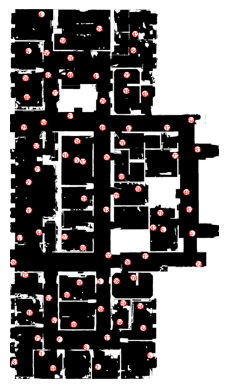

gpt-4o response: 
{
    "observation": "From the start (S) to the destination (D), there appear to be three main corridor routes. After going out from the start room (78), there is a junction (79) leading to three paths: one through the left corridor (46), one through the middle path (41), and another one through the right corridor (18) to reach the destination (D).",
    "paths": {
        "path_1": ["S", "78", "79", "46", "41", "D"],
        "path_2": ["S", "78", "79", "41", "D"],
        "path_3": ["S", "78", "79", "18", "D"]
    }
}
['S', '78', '79', '46', '41', 'D']
['S', '78', '79', '41', 'D']


KeyboardInterrupt: 

In [25]:
# test

import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)
importlib.reload(path_finding)
num_samples = 3
navigation_instruct1 = "send a secret file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"

source_nodes = ["office_4", "office_10", "office_10"]
target_nodes = ["office_14", "conferenceRoom_1", "WC_2"]


s_start = all_centers[source_nodes[1]]
s_end = all_centers[target_nodes[1]]

buffered, valid_points = generate_landmarks(s_start, s_end, top_view_map, obstacle_map)
obstacle_map_rgb = np.stack([obstacle_map] * 3, axis=-1)
obstacle_map_rgb = (obstacle_map_rgb * 255).astype(np.uint8)
obs_with_lm = path_finding.write_landmark_name(obstacle_map_rgb, valid_points)
# obs_with_lm = Image.fromarray(obstacle_map_rgb)
buffered_obs = BytesIO()
obs_with_lm.save(buffered_obs, format="JPEG")
plt.imshow(obs_with_lm)
plt.axis('off')  # 隐藏坐标轴
plt.show()

message = chat_utils.path_message_prepare(system_prompt.find_path_prompt, buffered, buffered_obs)
response_message = chat_utils.chat_with_gpt4v(message)
ground_json = response_message["paths"]

all_topo_paths = []
for k, v in ground_json.items():
    all_topo_paths.append(v)
    
all_geo_paths = path_finding.path_plan_from_topo_graph_for_large(all_topo_paths, obstacle_map, valid_points)

candidate_map_list = []
for i, geo_path in enumerate(all_geo_paths):
    map_with_path = top_view_map.copy()
    x_indices, y_indices = zip(*geo_path)
    path_map = np.zeros(obstacle_map.shape)
    path_map[x_indices, y_indices] = 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
    path_map = cv2.dilate((path_map).astype('uint8'), kernel)
    map_with_path[path_map == 1] = [255, 0 , 0]
    
    map_with_path = path_finding.write_number(map_with_path, i)
    # map_with_path = path_finding.write_scene_name(map_with_path, valid_points)
    buffered = BytesIO()
    map_with_path.save(buffered, format="JPEG")
    candidate_map_list.append(buffered)

    # 使用 Matplotlib 显示图像
    # 使用 Matplotlib 显示图像.
    # map_with_path.save(save_directory+f"vis_{i}.png")
    plt.imshow(map_with_path)
    plt.axis('off')  # 隐藏坐标轴
    plt.show()
    


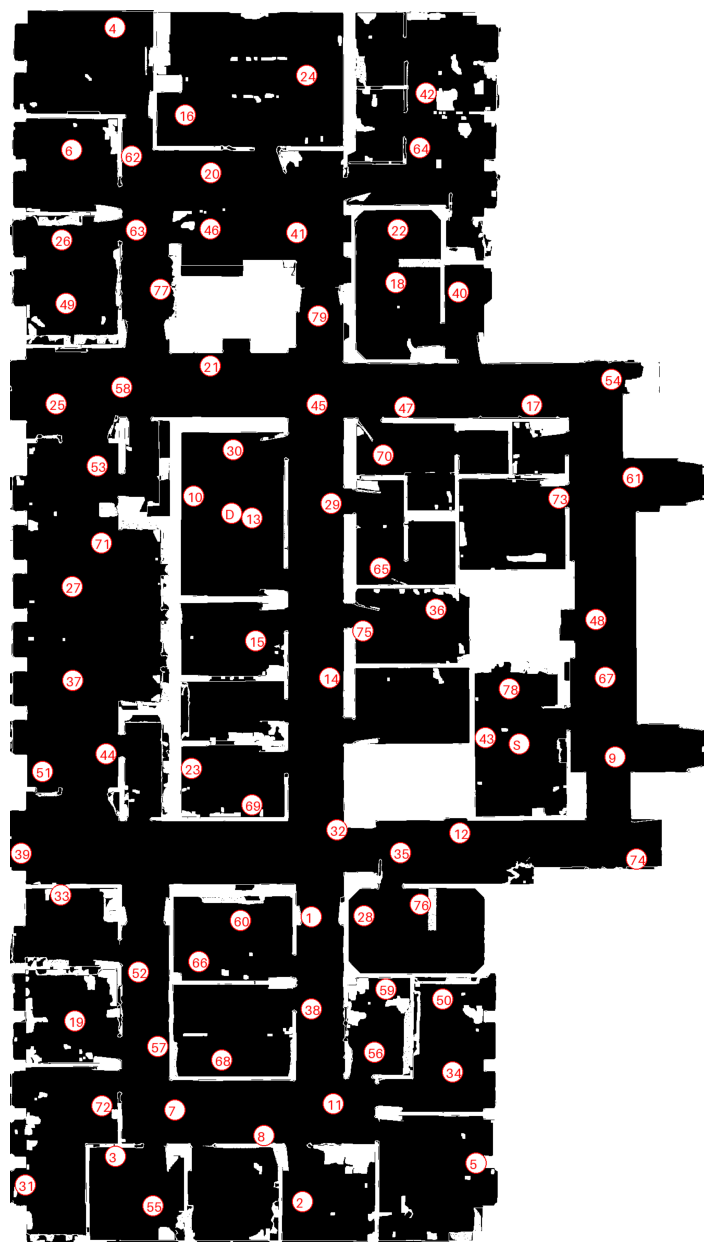

In [30]:
importlib.reload(path_finding)
obstacle_map_rgb = np.stack([obstacle_map] * 3, axis=-1)
obstacle_map_rgb = (obstacle_map_rgb * 255).astype(np.uint8)
obs_with_lm = path_finding.write_landmark_name(obstacle_map_rgb, valid_points)
plt.figure(figsize=(20, 16)) 
plt.imshow(obs_with_lm)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [39]:
importlib.reload(chat_utils)
importlib.reload(system_prompt)

critique_message = chat_utils.critique_message_prepare(system_prompt.self_critique_prompt, candidate_map_list)

response_message = chat_utils.chat_with_gpt4v(message+critique_message)
ground_json = response_message["self_critique"]
print(ground_json)
while ground_json == "0":
    all_topo_paths = []
    for k, v in response_message["paths"].items():
        all_topo_paths.append(v)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph_for_large(all_topo_paths, obstacle_map, valid_points)

    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = top_view_map.copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number(map_with_path, i)
        # map_with_path = path_finding.write_scene_name(map_with_path, valid_points)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像.
        # map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    critique_message = chat_utils.critique_message_prepare(system_prompt.self_critique_prompt, candidate_map_list)

    response_message = chat_utils.chat_with_gpt4v(message+critique_message)
    ground_json = response_message["self_critique"]

gpt-4o response: 
{
    "self_critique": "1"
}
1


gpt-4o response: 
{
    "observation": "From the start (S) to the destination (D), there appear to be three main routes. After stepping out of the start room (65) into the corridor (54), there is an intersection that branches left via (43), up via (3), or right via (11). All ultimately converge near (64) or (33) and lead to the destination (63).",
    "paths":{
        "path_1": ["S", "65", "54", "43", "77", "64", "63", "D"],
        "path_2": ["S", "65", "54", "3", "64", "63", "D"],
        "path_3": ["S", "65", "54", "11", "33", "63", "D"]
    }
}
['S', '65', '54', '43', '77', '64', '63', 'D']
['S', '65', '54', '3', '64', '63', 'D']
['S', '65', '54', '11', '33', '63', 'D']


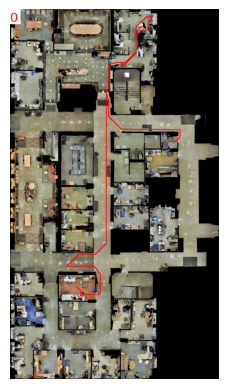

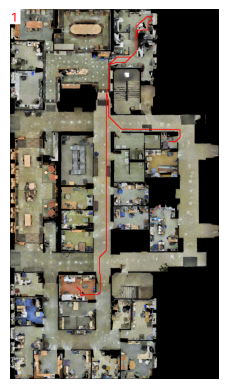

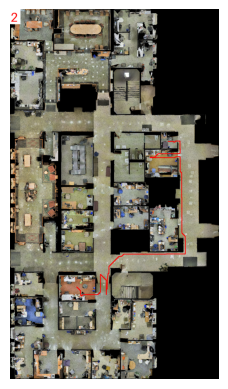

gpt-4o response: 
{
    "self_critique": "0", 
    "plan": "The red‐lined ‘0’ and ‘1’ are effectively the same corridor route (a small difference near the stair does not produce a genuinely separate path), and one distinct alternative is shown by the line labeled ‘2.’ To remove duplicates and include only genuinely different walkways, we merge routes ‘0’ and ‘1’ into one path and keep ‘2’ as the second distinct route.",
    "paths": {
        "path_1": ["S", "65", "36", "69", "63", "D"],
        "path_2": ["S", "65", "9", "21", "63", "D"]
    }
}
0
['S', '65', '36', '69', '63', 'D']
['S', '65', '9', '21', '63', 'D']


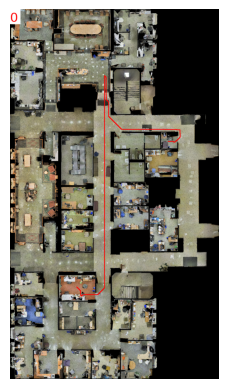

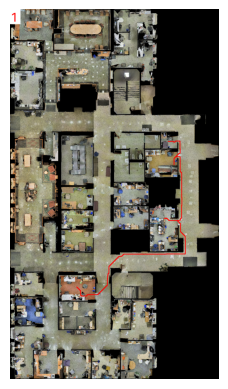

gpt-4o response: 
{
    "self_critique": "1"
}


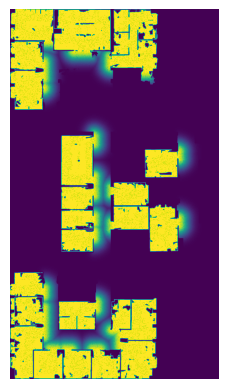

value:  270.2568927442908
distance:  2406
value:  617.226535151321
distance:  1947
gpt-4o response: 
{
    "observation": "Path 0 passes through the large central corridor near conference and meeting spaces, likely with higher foot traffic. Path 1 runs along smaller side corridors, passing fewer open areas and potentially fewer people.",
    "reason": "Although both paths can reach the same destination, avoiding the main corridor is preferable for transporting sensitive materials, as it minimizes exposure to high-occupancy common areas.",
    "self-critique": "The choice is based on the apparent occupant density of each route rather than real-time data. In practice, verifying actual usage patterns or scheduling times of lower traffic could further refine the route selection.",
    "path_id": "1"
}
1
select  1
gpt-4o response: 
{
    "observation": "From the start (S) to the destination (D) on this new layout, there also appear to be three main corridor routes. After exiting the start a

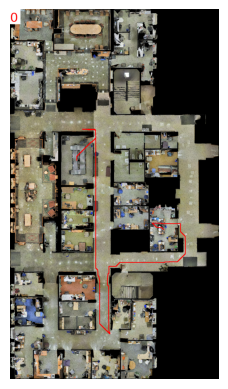

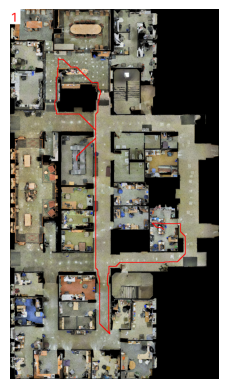

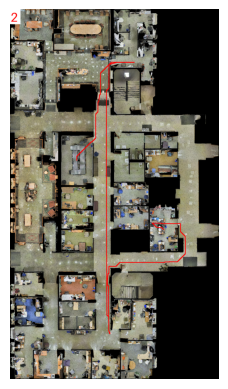

gpt-4o response: 
{
    "self_critique": "1"
}
1


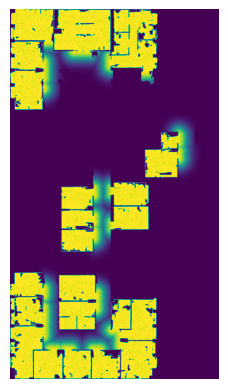

value:  717.6627672689427
distance:  3032
value:  779.0399720426333
distance:  4022
value:  880.118268403479
distance:  4024
gpt-4o response: 
{
  "observation": "Path 0 and Path 1 both route through a large open area adjacent to multiple occupied workstations, whereas Path 2 travels primarily along a central corridor with fewer open workstations and avoids the larger communal space.",
  "reason": "Because the equipment is fragile and must be kept away from potential crowds or high-activity zones, the corridor-based approach in Path 2 offers reduced exposure to office areas, decreasing the chance of accidental impact or observation.",
  "self-critique": "I focused on identifying high-occupancy areas and minimizing human traffic. Further refinements could include advanced sensing or scheduling transit during off-peak times to further reduce exposure and risk.",
  "path_id": "2"
}
2
select  2
gpt-4o response: 
{
    "observation": "From the start (S) at room 30 up to the destination (D) 

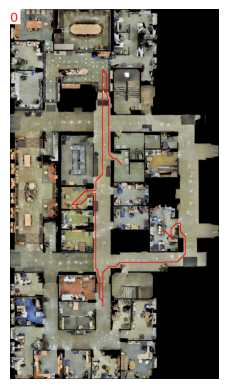

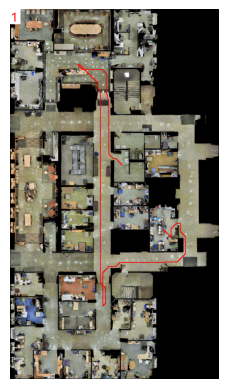

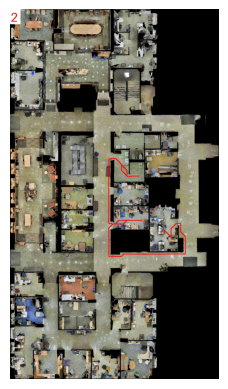

gpt-4o response: 
{
    "self_critique": "0", 
    "plan": "In the posted red‐line routes, the middle two are effectively the same physical corridor with only a slight jog near the open lounge.  We can merge those as a single path.  The other red‐line trace that loops through the offices is indeed a distinct corridor route.  We also remove offices that do not affect traversal from S to D.  The final two distinct, non‐redundant paths are:",
    "paths": {
        "path_1": ["S","30","7","11","29","17","21","D"],
        "path_2": ["S","30","9","45","69","D"]
    }
}
0
['S', '30', '7', '11', '29', '17', '21', 'D']
['S', '30', '9', '45', '69', 'D']


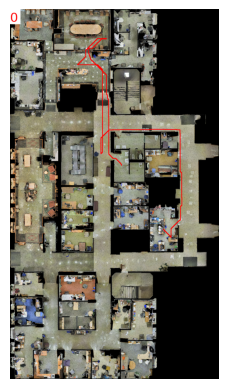

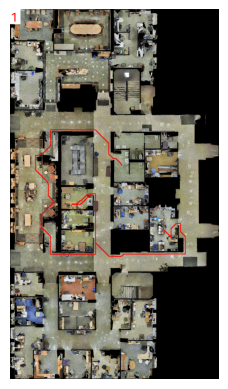

gpt-4o response: 
{
    "self_critique": "0", 
    "plan": "Some of the red‐line routes looped through interior offices or repeated the same corridor. Below are the pared‐down, truly distinct walkable paths between S and D, listing only the necessary corridor landmarks:",
    "paths":{
        "path_1": ["S","7","11","29","17","21","D"],
        "path_2": ["S","62","36","7","11","29","17","21","D"]
    }
}
['S', '7', '11', '29', '17', '21', 'D']
['S', '62', '36', '7', '11', '29', '17', '21', 'D']


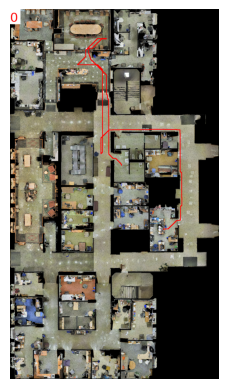

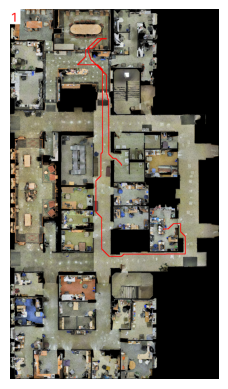

gpt-4o response: 
{
    "self_critique": "0", 
    "plan": "There is essentially one main corridor up from S to D, but it can be traversed via either a direct hallway or by looping briefly past another open area. We remove extra detours and focus on those two distinct walkable ways.",
    "paths":{
        "path_1": ["S", "30", "7", "22", "D"],
        "path_2": ["S", "30", "7", "36", "22", "D"]
    }
}
['S', '30', '7', '22', 'D']
['S', '30', '7', '36', '22', 'D']


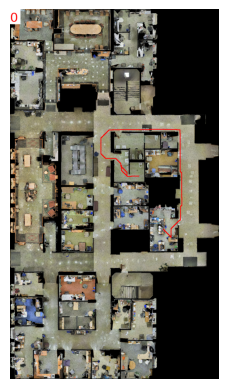

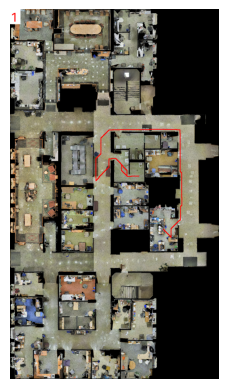

gpt-4o response: 
{
    "self_critique": "0", 
    "plan": "The red‐lined path loops around extra halls that can be bypassed. A simpler direct route avoids unnecessary detours. From S, go out through (30), continue up the main corridor past (7), turn toward (22), then enter D. This removes repeated or irrelevant segments.",
    "paths":{
        "path_1": ["S","30","7","22","D"]
    }
}
['S', '30', '7', '22', 'D']


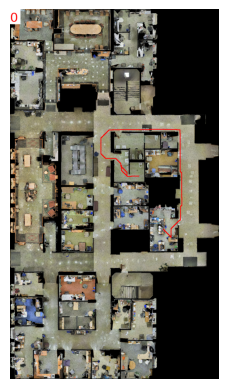

gpt-4o response: 
{
    "self_critique": "0", 
    "plan": "The red‐lined path loops through extra office areas instead of sticking to the main corridors, and it omits at least one shorter alternative hallway route. Below are two cleaner, distinct corridor routes that avoid unnecessary detours and include only the needed landmarks.",
    "paths":{
        "path_1": ["S","30","78","10","D"],
        "path_2": ["S","30","9","36","13","D"]
    }
}
['S', '30', '78', '10', 'D']
['S', '30', '9', '36', '13', 'D']


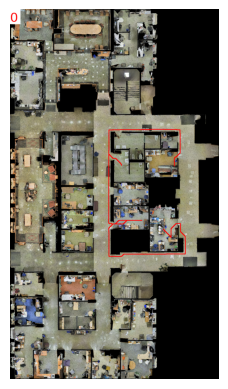

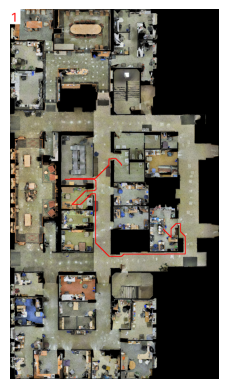

gpt-4o response: 
{
    "self_critique": "0",
    "plan": "Several of the red‐outlined ‘routes’ are really just bounding lines rather than actual step‐by‐step corridors from S to D. Also, some corridors that do provide alternate walks were not shown. Below is a streamlined set of truly distinct, walkable paths with no unnecessary detours, referencing key hallway landmarks.",
    "paths":{
        "path_1": ["S", "30", "9", "36", "11", "D"],
        "path_2": ["S", "30", "16", "36", "11", "D"]
    }
}
['S', '30', '9', '36', '11', 'D']
['S', '30', '16', '36', '11', 'D']


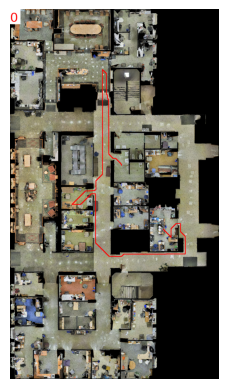

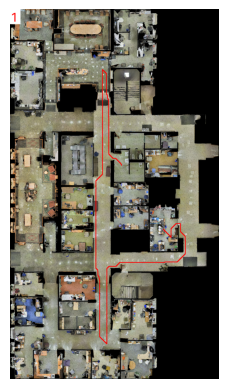

gpt-4o response: 
{
    "self_critique": "0", 
    "plan": "There is effectively just one main corridor path here (the second ‘red‐line’ is mostly the same hallway with a small detour). Also, a left‐side alternative corridor was missed. We remove the redundant route and add the missing left‐side route. The final distinct corridor paths are:",
    "paths":{
        "path_1": ["S","30","7","D"],
        "path_2": ["S","30","39","11","D"]
    }
}
['S', '30', '7', 'D']
['S', '30', '39', '11', 'D']


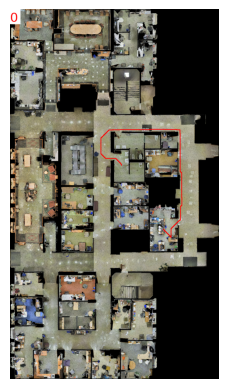

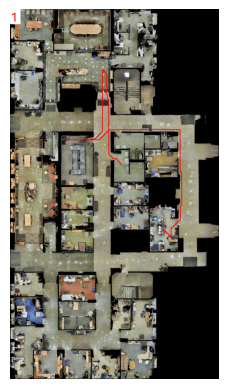

gpt-4o response: 
{
    "self_critique": "1"
}


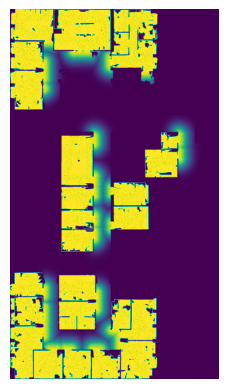

value:  326.44380589887555
distance:  1489
value:  791.1147269979301
distance:  2745
gpt-4o response: 
{
    "observation": "Path 0 skirts around the outer hallway by private offices, whereas Path 1 passes through the busier central corridor near open work areas.",
    "reason": "Although both routes traverse office zones, Path 0 stays closer to smaller single offices and avoids large, open-plan areas. This reduces the likelihood of encountering groups of people and maintains better privacy for transporting medicine.",
    "self-critique": "In selecting the route, I focused on minimizing foot traffic and personal exposure. A possible refinement would be to identify any after-hours or low-occupancy times to further reduce encounters along either path.",
    "path_id": "0"
}
0
select  0
A* baseline result: 
total_shortest_score:  816.852130880091
total_shortest_distance:  4228
PAN baseline result: 
total_privacy_score:  1823.7886094536755
total_privacy_distance:  7460


In [7]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)

num_samples = 5
navigation_instruct1 = "send a secret file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"

source_nodes = ["office_4", "office_10", "office_10"]
target_nodes = ["office_14", "conferenceRoom_1", "WC_2"]


total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)
    p_v, dis, a_star_privacy, a_star_distance = get_metric(source_node, target_node, all_geo_paths)
    
    total_shortest_score += a_star_privacy
    total_shortest_distance += a_star_distance
    
    navigation_instruct = navigation_instruct1
    if "conference" in target_node:
        navigation_instruct = navigation_instruct2
    elif "WC" in target_node:
        navigation_instruct = navigation_instruct3
    message = chat_utils.message_prepare(system_prompt.infer_prompt, candidate_map_list, navigation_instruct)
            
    ground_json = chat_utils.chat_with_gpt4v(message)
    print(ground_json["path_id"])
    index = int(ground_json["path_id"])

    print("select ", index)
    total_privacy_score += p_v[index]
    total_privacy_distance += dis[index]
    
    
print("A* baseline result: ")
print("total_shortest_score: ", total_shortest_score)
print("total_shortest_distance: ", total_shortest_distance)

print("PAN baseline result: ")
print("total_privacy_score: ", total_privacy_score)
print("total_privacy_distance: ", total_privacy_distance)